<h1 style="text-align:center"> Probabilistic programming, why we need it in business settings </h1>

<h2 style="text-align:center"> Luciano Paz </h2>

<div style="width: 50%; float: left; text-align: center; margin-left: 20%;">
    <p style="text-align: center">
    <img style="display:inline-block; width: 20%; vertical-align:middle;" src="pymc-labs-logo.png"> Principal Data Scientist
    </p>
    <p style="text-align: center">
    <img style="display:inline-block; width: 20%; vertical-align:middle;" src="https://raw.githubusercontent.com/pymc-devs/pymc/main/docs/logos/PyMC.png"> core maintainer
    </p>
</div>
<div style="margin-left: 70%; width: 20%;">
    <img style="float: right; width: 100%; border-radius: 20%; vertical-align:middle;" src="https://raw.githubusercontent.com/lucianopaz/my_website_source/master/content/authors/lucianopaz/avatar.jpg">
</div>
<div style="margin-top: 15%;">
    Presentation notebook available at <a href="https://github.com/lucianopaz/ghost_day">https://github.com/lucianopaz/ghost_day</a>
</div>

## Outline

1. Introduce the problem
1. How to reason about uncertainty?
1. Introduce extra complexity into the problem. Regular methods can't cope, but PPLs can
1. PPLs can naturally leverage the posterior for stat decision making
1. Show different flavours of complexity and how PPLs can adapt
1. What are the limits of PPLs?
1. Other problems that are suitable for PPLs

Potential problems:

- Comparing two variants of a product to see which gives more conversions
- Comparing two providers to see which gives the highest cost/benefit ratio
- Average revenue per user
- Average treatment effect

##  Reasoning and making decisions in the face of uncertainty

- All businesses make decisions based upon the available noisy data
    - Which advertisement campaign to use?
    - How to distribute their marketing budget?
    - Will my product be effective in the market?
    - How will demand change in the next quarter?

Decisions informed by data must:
- Take into account variability in data
- Be based on business logic (expected uplift or loss)

<p style="text-align: center">
    <img style="display:inline-block; width: 40%; vertical-align:middle; " src="pymc-labs-logo.png">
</p>

At PyMC Labs we help companies make decisions based on their data

Most of our work is in

- Marketing
- Pharma

Here, I'll focus on a common marketing problem: A/B tests

##  Reasoning in the face of uncertainty

#### A/B tests

**Goal:** learn out of two product variants which leads to better performance.

##### Examples

- Which of two advertisement layouts lead to more clicks?
- Which video thumbnail leads to more views?
- Which color of a toy leads to more purchases?

## How are A/B tests done?

- Split the potential customer audience into two groups
- Show each group one variant of the product
- Measure how many members of each group perform a desired action (buy, click, view, etc)

## After finishing an A/B test, what do we know?

- Audience sizes of each group
- Number of desired actions of each group (we'll call these conversions)

### If we repeat the same experiment a second time

- The number of participants in the test might be different
- The number of conversions might be different

## **What do we want to learn?**

- How likely is it that a potential future customer converts

## What is probabilistic programming and why does it help us?

Probabilistic Programming Languages (PPLs) provide a way to:

- Explicitly write down the random process that is assumed to **generate your observations** (model generative process)
- Incorporate any **prior business or expert knowledge** into the generative process
- **Learn (infer) the unobserved model parameters** from the observed data
- Use the inferred quantities to do business predictions that are **aware of uncertainty**

## Why do we need PPLs?

They give the flexibility to incorporate any form of dynamic into the data generation process

- Temporal structure
- Existence of cohorts in the data
- Nested structure (e.g. geographical structure)
- Missing data

##  Tools to reason in the face of uncertainty

There are many PPLs:
<p>
    <img style="display:inline-block; width: 20%; vertical-align:middle;" src="https://raw.githubusercontent.com/pymc-devs/pymc/main/docs/logos/PyMC.png"> and many others like turing.jl, emcee, pyro, Tensorflow Probability, Edward, Stan
</p>

A/B test scenario

- We assume that each variant has some unknown conversion rate
- The number of conversions depends on the unknown conversion rate

$$
p \sim \text{Beta}(\alpha, \beta)\\
k \sim \text{Binomial}(p, n)
$$

Learning the unknown parameters can be done with **Bayes inference**

Why is Bayes inference good?

- Naturally encodes uncertainty of the unobserved model parameters
- Can be applied to most model structures
- Inference results can be used to drive data based decisions that are aware of uncertainty

In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
from matplotlib import pyplot as plt
from scipy.special import expit

RANDOM_SEED = 52

In [2]:
times = pd.date_range("2021-04-03", "2021-05-01", freq="1D")
x = ((times - times[0]) / np.timedelta64(1, "D")).values
weekday = times.weekday.values
is_weekend = weekday > 4

In [3]:
rng = np.random.default_rng(RANDOM_SEED)

In [4]:
traffic_rate1 = np.array(
    [[100, 100, 100, 100, 100, 500, 500], [100, 100, 100, 100, 100, 500, 500],]
).T
traffic_rate2 = np.array(
    [[100, 100, 100, 100, 100, 500, 500], [100, 100, 100, 100, 100, 500, 500],]
).T

In [5]:
n1 = rng.poisson(np.take_along_axis(traffic_rate1, weekday[:, None], axis=0))
n2 = rng.poisson(np.take_along_axis(traffic_rate2, weekday[:, None], axis=0))

In [6]:
groups = ["A", "B"]
weekend_effect = np.array([[0, -0.3]])
weekend_effect2 = np.array([[0, 0.4]])
offset1 = np.array([-2.8, -2.5])
offset2 = np.array([-2.8, -2.8])

p1 = expit(offset1 + weekend_effect * is_weekend[:, None])
p2 = expit(offset2 + weekend_effect2 * is_weekend[:, None])
k1 = rng.binomial(n=n1, p=p1)
k2 = rng.binomial(n=n2, p=p2)

# Sum across everything
k1_all = np.sum(k1)
k2_all = np.sum(k2)
n1_all = np.sum(n1)
n2_all = np.sum(n2)

# Sum across groups
k1_days = np.sum(k1, axis=-1)
k2_days = np.sum(k2, axis=-1)
n1_days = np.sum(n1, axis=-1)
n2_days = np.sum(n2, axis=-1)

# Sum across days
k1_groups = np.sum(k1, axis=0)
k2_groups = np.sum(k2, axis=0)
n1_groups = np.sum(n1, axis=0)
n2_groups = np.sum(n2, axis=0)

# Simple A/B test example

You perform an A/B test to compare two variants of a product

In [7]:
print(f"Total customers exposed to old variant: {n1_all}")
print(f"Total customers exposed to new variant: {n2_all}")
print(f"Total conversions with old variant: {k1_all}")
print(f"Total conversions with new variant: {k2_all}")
print(f"Conversion rate with old variant: {np.round(k1_all / n1_all, 3)}")
print(f"Conversion rate with new variant: {np.round(k2_all / n2_all, 3)}")

Total customers exposed to old variant: 12868
Total customers exposed to new variant: 12780
Total conversions with old variant: 808
Total conversions with new variant: 828
Conversion rate with old variant: 0.063
Conversion rate with new variant: 0.065


Writting down the data generation process as a model is straightforward with PyMC

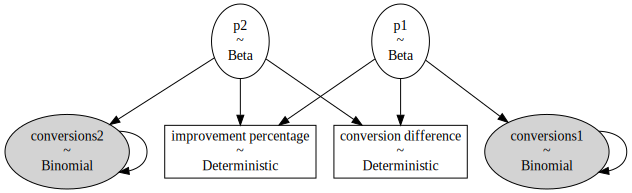

In [8]:
with pm.Model() as model1:
    p1 = pm.Beta("p1", alpha=1, beta=10)
    p2 = pm.Beta("p2", alpha=1, beta=10)
    pm.Deterministic("conversion difference", p2 - p1)
    pm.Deterministic("improvement percentage", (p2 / p1 - 1) * 100)
    pm.Binomial("conversions1", p=p1, n=n1_all, observed=k1_all)
    pm.Binomial("conversions2", p=p2, n=n2_all, observed=k2_all)
pm.model_to_graphviz(model1)

Once the data generation process has been programmed, Bayes inference is done automatically

In [9]:
with model1:
    idata = idata1 = pm.sample(
        return_inferencedata=True, chains=4, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [p1, p2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


The inference results encode the uncertainty about business variables:

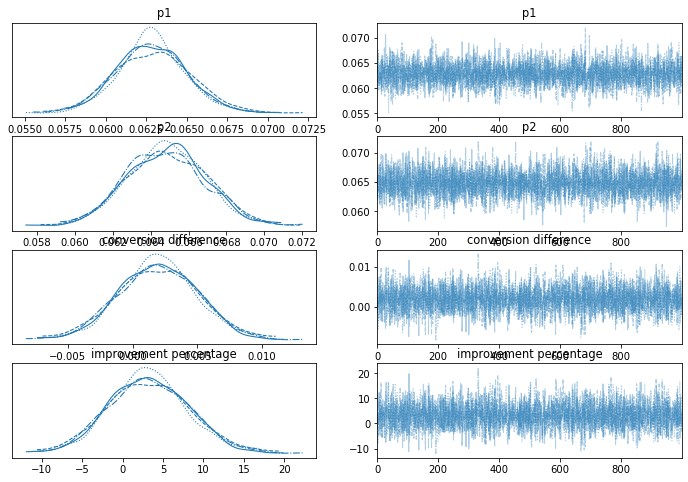

In [10]:
az.plot_trace(idata);

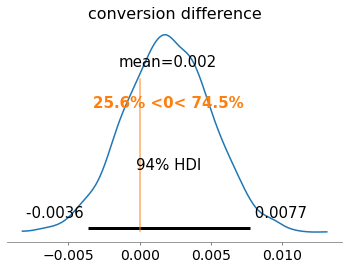

In [11]:
az.plot_posterior(idata, var_names=["conversion difference"], ref_val=0);

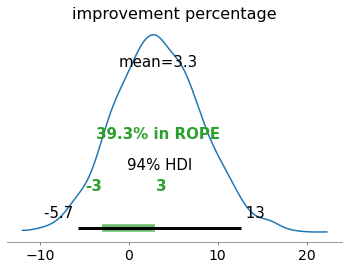

In [12]:
az.plot_posterior(
    idata, var_names=["improvement percentage"], rope=[-3, 3],
);

## The uncertainty can be used to make data driven decisions

The generative process can be used to compute the probability that your business will win or lose money

```python
def make_decision(
    idata, cost_benefit_ratio1, cost_benefit_ratio2,
):
    loss_1 = cost_benefit_ratio1 - idata.posterior.p1
    loss_2 = cost_benefit_ratio2 - idata.posterior.p2
    loss_difference = loss_2 - loss_1
    expected_utility = loss_difference.mean(["chain", "draw"])
    decision = xr.where(expected_utility < 0, "Use new", "Use old")
    ...
    return decision
```

Can also compute measures like:
- expected uplift (if variant b is better than a, how much money do I expect to make)
- expected loss (if variant b is worse than a, how much money do I expect to lose)

In [13]:
def make_decision(
    idata, cost_benefit_ratio1, cost_benefit_ratio2,
):
    loss_1 = cost_benefit_ratio1 - idata.posterior.p1
    loss_2 = cost_benefit_ratio2 - idata.posterior.p2
    loss_difference = loss_2 - loss_1
    expected_utility = -loss_difference.mean(["chain", "draw"])
    decision = xr.where(expected_utility > 0, "Use new", "Use old")
    expected_uplift = -(xr.where(loss_difference <= 0, loss_difference, np.nan)).mean(
        ["chain", "draw"]
    )
    expected_uplift = expected_uplift.fillna(0)
    expected_loss = (xr.where(loss_difference >= 0, loss_difference, np.nan)).mean(
        ["chain", "draw"]
    )
    expected_loss = expected_loss.fillna(0)
    return xr.Dataset(
        {
            "decision": decision,
            "expected_utility": expected_utility,
            "expected_uplift": expected_uplift,
            "expected_loss": expected_loss,
        }
    )

In [14]:
decision_output1 = make_decision(
    idata1, cost_benefit_ratio1=0.01, cost_benefit_ratio2=0.015
)
print(f"Decision outcome: {decision_output1.decision.data}")
print(f"Expected utility: {np.round(decision_output1.expected_utility.data, 4)}")
print(f"Expected uplift: {np.round(decision_output1.expected_uplift.data, 4)}")
print(f"Expected loss: {np.round(decision_output1.expected_loss.data, 4)}")

Decision outcome: Use old
Expected utility: -0.003
Expected uplift: 0.0016
Expected loss: 0.0039


## A/B tests are not as simple as the seem

- A/B tests are carried out during a period of time, they can show temporal structure
- Subjects involved in the test can belong to different cohorts, and their behavior might be different
- You might have unbalanced cohorts for different time periods, or contexts
- Your measured quantity might not be binary (e.g. how long does a subject watch a video? How many items a subject purchases?)
- Your observations might be skewed and zero-inflated (big departure from normal distributions)

### Temporal structure

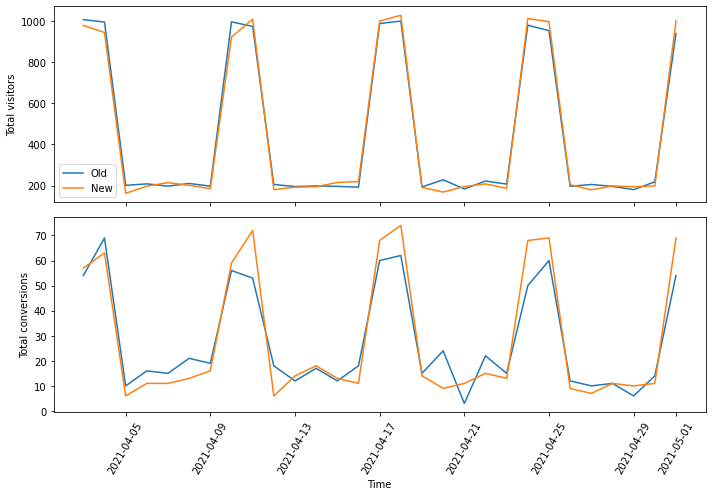

In [15]:
f, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 7))
ax = axs[0]
ax.plot(times, n1_days, label="Old")
ax.plot(times, n2_days, label="New")
ax.set_ylabel("Total visitors")
ax.legend()
ax = axs[1]
ax.plot(times, k1_days, label="Old")
ax.plot(times, k2_days, label="New")
ax.set_ylabel("Total conversions")
ax.set_xlabel("Time")
ax.tick_params("x", labelrotation=60)
f.tight_layout()

![temporal_structure](temporal_structure.png)

### Can we still use PPLs when our observations have temporal structure?

**YES**

- Inference more or less always uses the same technique
- The user's work is to specify the generative process (i.e. the model)

Let's add time into the model. We'll just assume that business days are different than weekends

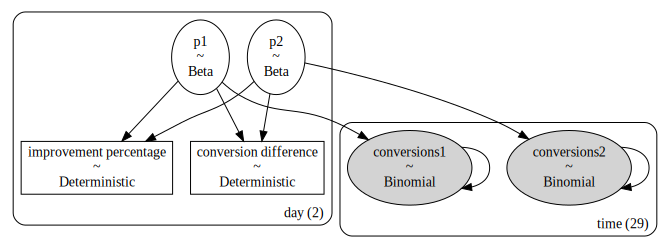

In [16]:
coords = {"time": times, "day": ["business day", "weekend"]}
with pm.Model(coords=coords) as model2:
    p1 = pm.Beta("p1", alpha=1, beta=10, dims="day")
    p2 = pm.Beta("p2", alpha=1, beta=10, dims="day")
    pm.Deterministic("conversion difference", p2 - p1, dims="day")
    pm.Deterministic("improvement percentage", (p2 / p1 - 1) * 100, dims="day")
    _p1 = pm.aesaraf.take_along_axis(p1, is_weekend.astype("int"), axis=0)
    _p2 = pm.aesaraf.take_along_axis(p2, is_weekend.astype("int"), axis=0)
    pm.Binomial("conversions1", p=_p1, n=n1_days, dims="time", observed=k1_days)
    pm.Binomial("conversions2", p=_p2, n=n2_days, dims="time", observed=k2_days)
pm.model_to_graphviz(model2)

The inference step does not change

In [17]:
with model2:
    idata = idata2 = pm.sample(
        return_inferencedata=True, chains=4, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [p1, p2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


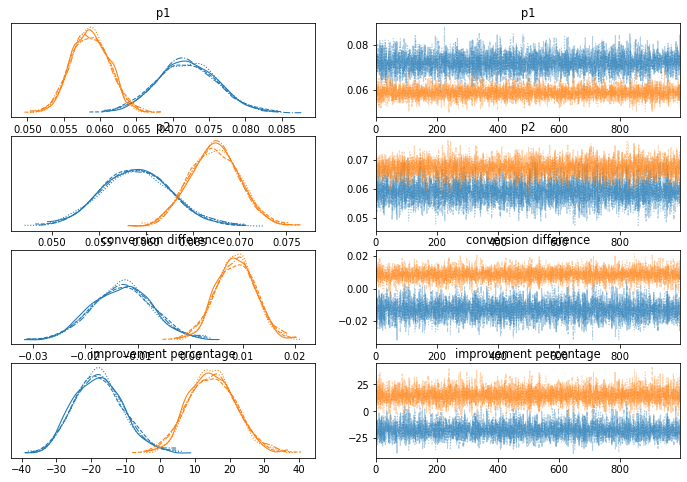

In [18]:
az.plot_trace(idata);

Does anything change in what we inferred?

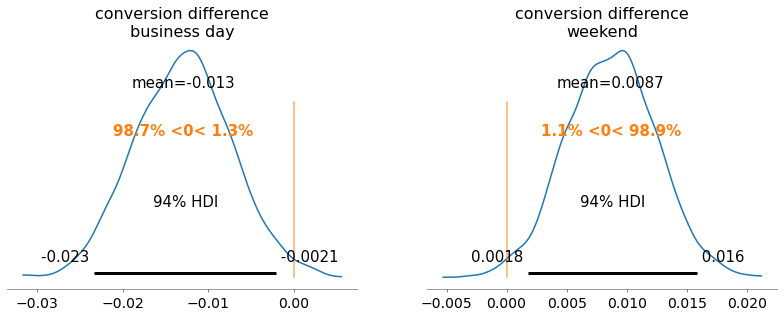

In [19]:
az.plot_posterior(idata, var_names=["conversion difference"], ref_val=0);

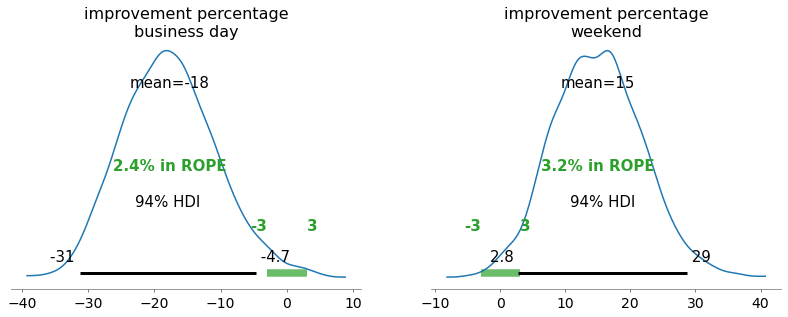

In [20]:
az.plot_posterior(
    idata, var_names=["improvement percentage"], rope=[-3, 3],
);

In [21]:
decision_output = decision_output2 = make_decision(
    idata2, cost_benefit_ratio1=0.01, cost_benefit_ratio2=0.015
)
print(f"Decision outcome: {decision_output.decision.data}")
print(f"Expected utility: {np.round(decision_output.expected_utility.data, 4)}")
print(f"Expected uplift: {np.round(decision_output.expected_uplift.data, 4)}")
print(f"Expected loss: {np.round(decision_output.expected_loss.data, 4)}")

Decision outcome: ['Use old' 'Use new']
Expected utility: [-0.018   0.0037]
Expected uplift: [0.0005 0.0048]
Expected loss: [0.018  0.0019]


# What if we identify two cohorts?

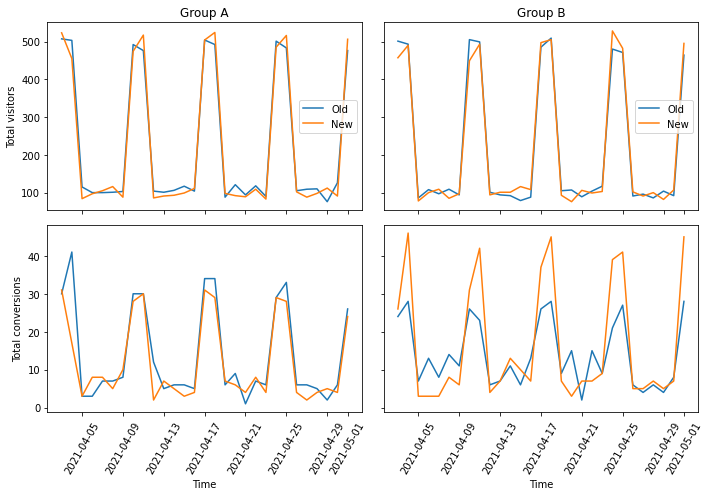

In [22]:
f, axs = plt.subplots(2, 2, sharex=True, sharey="row", figsize=(10, 7))
for group in range(2):
    ax = axs[0, group]
    ax.plot(times, n1[:, group], label="Old")
    ax.plot(times, n2[:, group], label="New")
    if group == 0:
        ax.set_ylabel("Total visitors")
    ax.legend()
    ax.set_title(f"Group {groups[group]}")
    ax = axs[1, group]
    ax.plot(times, k1[:, group], label="Old")
    ax.plot(times, k2[:, group], label="New")
    if group == 0:
        ax.set_ylabel("Total conversions")
    ax.set_xlabel("Time")
    ax.tick_params("x", labelrotation=60)
f.tight_layout()

![cohort_temporal_structure](cohort_temporal_structure.png)

In [23]:
k1_groups, k2_groups, n1_groups, n2_groups, np.round(
    k1_groups / n1_groups, 3
), np.round(k2_groups / n2_groups, 3)

(array([403, 405]),
 array([350, 478]),
 array([6522, 6346]),
 array([6436, 6344]),
 array([0.062, 0.064]),
 array([0.054, 0.075]))

If we still choose to aggregate the data over time to draw our conclusions:

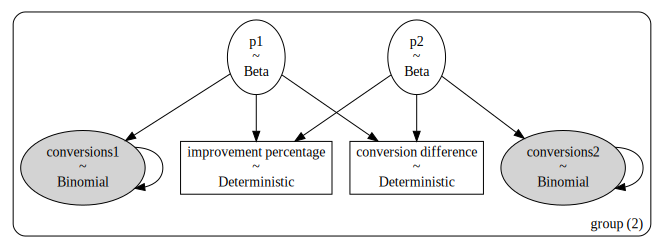

In [24]:
coords = {"group": groups}
with pm.Model(coords=coords) as model3:
    p1 = pm.Beta("p1", alpha=1, beta=10, dims="group")
    p2 = pm.Beta("p2", alpha=1, beta=10, dims="group")
    pm.Deterministic("conversion difference", p2 - p1, dims="group")
    pm.Deterministic("improvement percentage", (p2 / p1 - 1) * 100, dims="group")
    pm.Binomial("conversions1", p=p1, n=n1_groups, dims="group", observed=k1_groups)
    pm.Binomial("conversions2", p=p2, n=n2_groups, dims="group", observed=k2_groups)
pm.model_to_graphviz(model3)

In [25]:
with model3:
    idata = idata3 = pm.sample(
        return_inferencedata=True, chains=4, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [p1, p2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


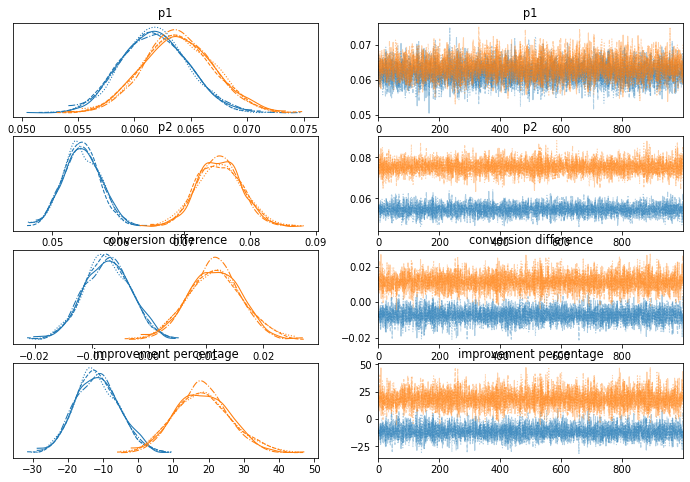

In [26]:
az.plot_trace(idata);

Now we infer something that is attributed to each cohort

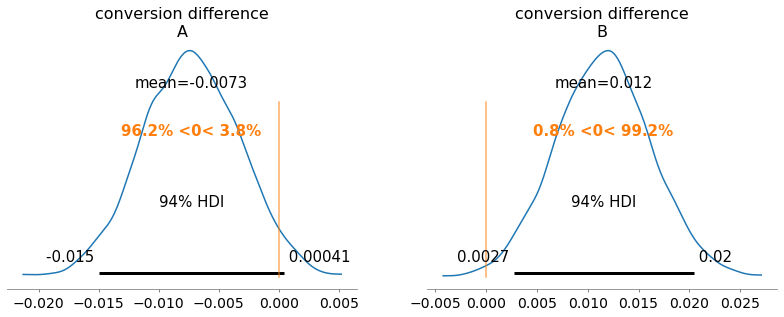

In [27]:
az.plot_posterior(idata, var_names=["conversion difference"], ref_val=0);

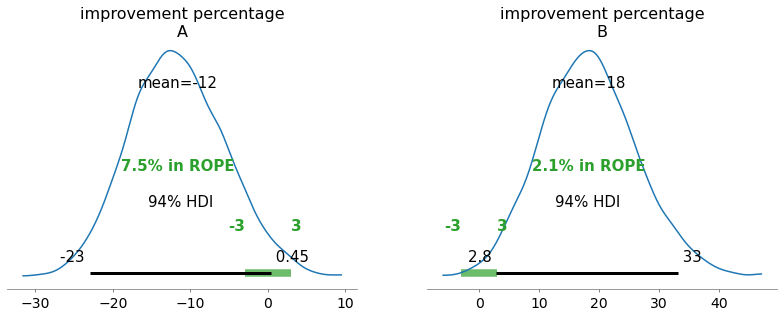

In [28]:
az.plot_posterior(
    idata, var_names=["improvement percentage"], rope=[-3, 3],
);

In [29]:
decision_output = decision_output3 = make_decision(
    idata3, cost_benefit_ratio1=0.01, cost_benefit_ratio2=0.015
)
print(f"Decision outcome: {decision_output.decision.data}")
print(f"Expected utility: {np.round(decision_output.expected_utility.data, 4)}")
print(f"Expected uplift: {np.round(decision_output.expected_uplift.data, 4)}")
print(f"Expected loss: {np.round(decision_output.expected_loss.data, 4)}")

Decision outcome: ['Use old' 'Use new']
Expected utility: [-0.0123  0.0065]
Expected uplift: [0.0002 0.0073]
Expected loss: [0.0123 0.0021]


## We can finally put everything together

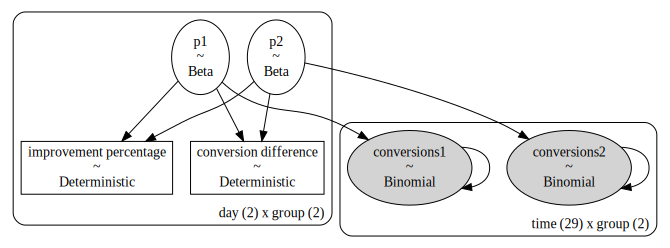

In [30]:
coords = {"time": times, "group": groups, "day": ["business day", "weekend"]}
with pm.Model(coords=coords) as model4:
    p1 = pm.Beta("p1", alpha=1, beta=10, dims=("day", "group"))
    p2 = pm.Beta("p2", alpha=1, beta=10, dims=("day", "group"))
    pm.Deterministic("conversion difference", p2 - p1, dims=("day", "group"))
    pm.Deterministic(
        "improvement percentage", (p2 / p1 - 1) * 100, dims=("day", "group")
    )
    _p1 = pm.aesaraf.take_along_axis(p1, is_weekend[:, None].astype("int"), axis=0)
    _p2 = pm.aesaraf.take_along_axis(p2, is_weekend[:, None].astype("int"), axis=0)
    pm.Binomial("conversions1", p=_p1, n=n1, dims=("time", "group"), observed=k1)
    pm.Binomial("conversions2", p=_p2, n=n2, dims=("time", "group"), observed=k2)
pm.model_to_graphviz(model4)

In [31]:
with model4:
    idata = idata4 = pm.sample(
        return_inferencedata=True, chains=4, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [p1, p2]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


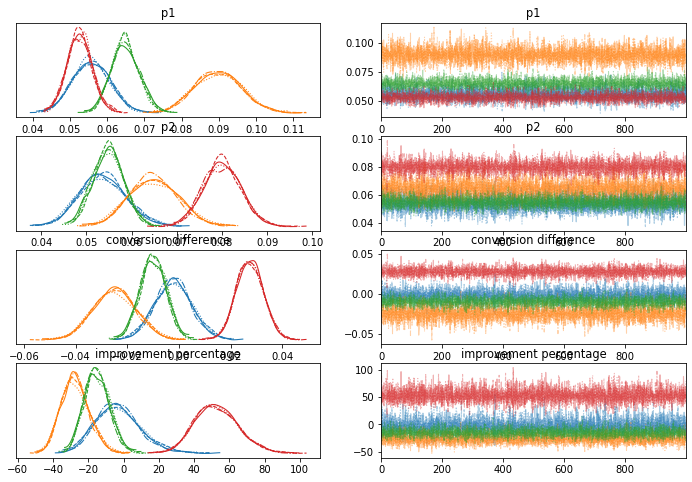

In [32]:
az.plot_trace(idata);

And now are inferred quantities will be conditioned by cohort and time

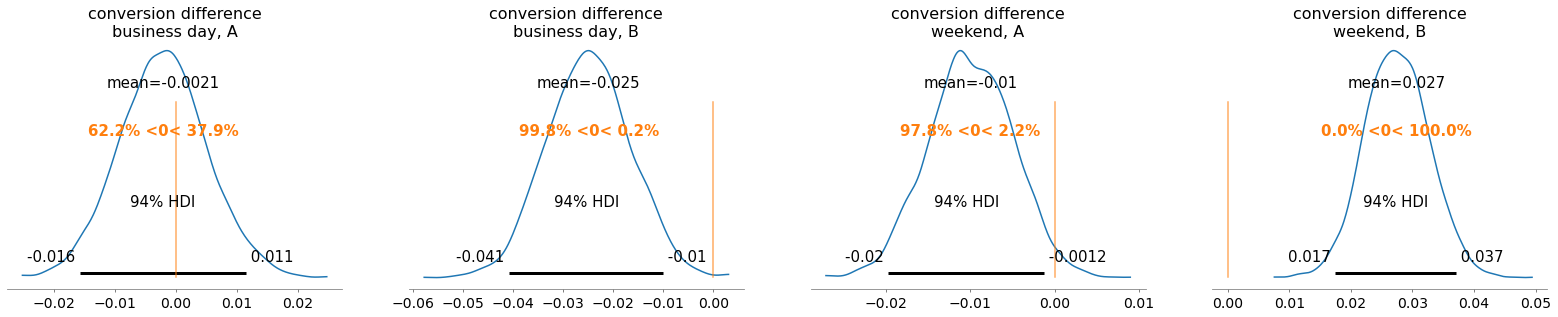

In [33]:
az.plot_posterior(idata, var_names=["conversion difference"], ref_val=0);

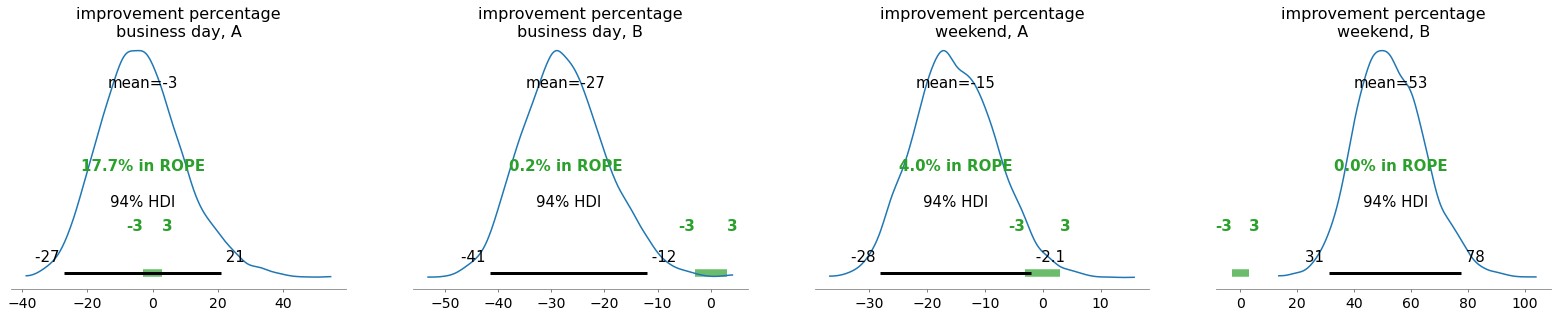

In [34]:
az.plot_posterior(
    idata, var_names=["improvement percentage"], rope=[-3, 3],
);

As such, our optimal decisions will be different according to group and day

In [35]:
loss4 = make_decision(idata4, cost_benefit_ratio1=0.01, cost_benefit_ratio2=0.015)
loss4.decision

<xarray.DataArray 'decision' (day: 2, group: 2)>
array([['Use old', 'Use old'],
       ['Use old', 'Use new']], dtype='<U7')
Coordinates:
  * day      (day) <U12 'business day' 'weekend'
  * group    (group) <U1 'A' 'B'

# Wrapping up

Only showed a PPL applied to A/B tests but they can be applied to many other business cases

- Average treatment effect in preclinical studies
- Media Mix Models for marketing budget allocation
- Survival analysis in clinical trials
- Customer life time models
- Supply chain optimization
- ...

## What are the limitations of PPLs?

- Computational complexity
- Mostly suitable when the observations have a computable likelihood (some exceptions like approximate Bayesian computation, ABC)

# Thank you for your attention!

In [36]:
%load_ext watermark
%watermark -v --iversions

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

matplotlib: 3.4.3
pymc      : 4.0.0b2
arviz     : 0.11.4
xarray    : 0.21.1
pandas    : 1.3.4
numpy     : 1.20.3

